In [4]:
# Mounting the Drive So as to share the Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing the Necessary Packages

import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns


In [0]:
# Attention Mechanism Definition code

# Defining a Dot Product for Theano or Tensorflow as backend
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


# Create Class AttentionWithContext based on Hierarchical Attention Networks for Document Classification Paper

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
# Import libraries

# We use shuffle function to randomize the sequence of items in a list
from sklearn.utils import shuffle


In [8]:
'''
# Import Data file to google Collab

from google.colab import files

upload = files.upload()
'''

'\n# Import Data file to google Collab\n\nfrom google.colab import files\n\nupload = files.upload()\n'

In [0]:
# Loading the Data from Drive mounted based on the 1st cell

df = shuffle(pd.read_json('/content/drive/My Drive/SPS_Dt/News_Category_Dataset_v2.json', lines=True)).reset_index()

In [10]:
# Check first 5 Rows of the Dataframe
df.head()

,index,category,headline,authors,link,short_description,date
0,198841,TECH,"Facebook Phone Loses Out To Amazon Phone, Cust...",Courteney Palis,https://www.huffingtonpost.com/entry/facebook-...,"For Amazon, on the other hand, well, this migh...",2012-02-19
1,50213,POLITICS,"Donald Trump Campaign, Republican Groups Targe...",,https://www.huffingtonpost.com/entry/hackers-t...,The report follows the hack of Democrat groups.,2016-08-19
2,141904,CULTURE & ARTS,"14 New, Must-See Public Artworks Across the Globe","ARTINFO, Contributor\nThe online authority for...",https://www.huffingtonpost.com/entry/must-see-...,On the eve of her 100th birthday (November 21)...,2013-10-19
3,63453,PARENTS,New York Zika Plan Will Include 'Protection Ki...,"Rachael Rettner, Live Science",https://www.huffingtonpost.com/entry/new-york-...,New York state officials have announced a new ...,2016-03-22
4,199230,TRAVEL,Top 10 Best Hotel Bathtubs (PHOTOS),"Tablet, Contributor\nContributor",https://www.huffingtonpost.com/entry/top-10-be...,We've all got our own particular requisites wh...,2012-02-14


In [11]:
# Check Last 5 Rows of the Dataframe
df.tail()

,index,category,headline,authors,link,short_description,date
200848,44764,POLITICS,Tim Kaine Says Trump Refusing To Concede The E...,Jeffrey Young,https://www.huffingtonpost.com/entry/tim-kaine...,“We’re confident in the American public that t...,2016-10-20
200849,117885,WOMEN,On Being a 'Badass' in Business: Tagging Smart...,"Kim Harris, ContributorChief Visionary Officer...",https://www.huffingtonpost.com/entry/on-being-...,Smart women entrepreneurs usually achieve high...,2014-07-10
200850,193913,WELLNESS,Got Allergies? Natural Ways To Ease Skin Problems,,https://www.huffingtonpost.com/entry/allergies...,"Puffy eyes, a red, runny nose -- allergy sympt...",2012-04-12
200851,29938,ENTERTAINMENT,Joan Baez Tears Into 'Future Dictator' Donald ...,Lee Moran,https://www.huffingtonpost.com/entry/joan-baez...,"""You better talk to a shrink because you’ve go...",2017-04-07
200852,96658,BUSINESS,The Growing Importance of Managers in Employee...,"Gail S. Thornton, ContributorCommunications pr...",https://www.huffingtonpost.com/entry/the-growi...,"Long overlooked, or at least given a lower pri...",2015-03-10


In [12]:
# Check how the Target variable is distributed
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [13]:
# Check the Rows and Columns of the dataset
df.shape

(200853, 7)

In [14]:
# Check the no of unique Test occurance, Multiclass problem
df.category.nunique()

41

In [0]:
# Create a Column through Feature Engineering, which combines Headline and Short Desctiption
# Change as per the Response

df["Context"] = df["headline"].map(str) + '. ' +df["short_description"]

In [16]:
# Validation
df.head()

,index,category,headline,authors,link,short_description,date,Context
0,198841,TECH,"Facebook Phone Loses Out To Amazon Phone, Cust...",Courteney Palis,https://www.huffingtonpost.com/entry/facebook-...,"For Amazon, on the other hand, well, this migh...",2012-02-19,"Facebook Phone Loses Out To Amazon Phone, Cust..."
1,50213,POLITICS,"Donald Trump Campaign, Republican Groups Targe...",,https://www.huffingtonpost.com/entry/hackers-t...,The report follows the hack of Democrat groups.,2016-08-19,"Donald Trump Campaign, Republican Groups Targe..."
2,141904,CULTURE & ARTS,"14 New, Must-See Public Artworks Across the Globe","ARTINFO, Contributor\nThe online authority for...",https://www.huffingtonpost.com/entry/must-see-...,On the eve of her 100th birthday (November 21)...,2013-10-19,"14 New, Must-See Public Artworks Across the Gl..."
3,63453,PARENTS,New York Zika Plan Will Include 'Protection Ki...,"Rachael Rettner, Live Science",https://www.huffingtonpost.com/entry/new-york-...,New York state officials have announced a new ...,2016-03-22,New York Zika Plan Will Include 'Protection Ki...
4,199230,TRAVEL,Top 10 Best Hotel Bathtubs (PHOTOS),"Tablet, Contributor\nContributor",https://www.huffingtonpost.com/entry/top-10-be...,We've all got our own particular requisites wh...,2012-02-14,Top 10 Best Hotel Bathtubs (PHOTOS). We've all...


In [0]:
# Choosing Context and Category Column from the Dataframe
df = df[['Context', 'category']]

In [18]:
# Check the last 10 df rows
df.tail(10)

,Context,category
200843,Price Difference Between These Near-Identical ...,STYLE
200844,The Best Way To Use Leftover Rice. Just call i...,TRAVEL
200845,Silence on Black Female Victims Weakens Fight ...,BLACK VOICES
200846,A Parent's Predicament: Does Winning at Work M...,PARENTING
200847,Immigrant Children Accuse Border Patrol Of Abu...,POLITICS
200848,Tim Kaine Says Trump Refusing To Concede The E...,POLITICS
200849,On Being a 'Badass' in Business: Tagging Smart...,WOMEN
200850,Got Allergies? Natural Ways To Ease Skin Probl...,WELLNESS
200851,Joan Baez Tears Into 'Future Dictator' Donald ...,ENTERTAINMENT
200852,The Growing Importance of Managers in Employee...,BUSINESS


In [19]:
# Check for any Missing Values
df.isna().sum()

Context     0
category    0
dtype: int64

In [20]:
# Check the info of the Trainable Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
Context     200853 non-null object
category    200853 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [0]:
# Defining a Text cleaning function to remove strings of "'\

import re
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [22]:
# Use NLTK

import nltk
nltk.download('punkt')
# Plunkt tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Performing Tokenisation based on sentence and word

paras = [] 
labels = []
texts = []
sent_lens = []
sent_nums = []

# Loop through all indexes in df.Context rows and clean/tokenise it
for idx in range(df.Context.shape[0]):
    text = clean_str(df.Context[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)


In [24]:
# Check for Lists with list of sentences in a record
paras[:10]

[['facebook phone loses out to amazon phone, customer survey says.',
  'for amazon, on the other hand, well, this might be the perfect time to take advantage.',
  'according to paidcontent, its likely'],
 ['donald trump campaign, republican groups targeted by hackers: report.',
  'the report follows the hack of democrat groups.'],
 ['14 new, must-see public artworks across the globe.',
  'on the eve of her 100th birthday (november 21), the renowned japan-born brazil-based artist tomie ohtake just launched a'],
 ['new york zika plan will include protection kits for pregnant women.',
  'new york state officials have announced a new plan aimed at preventing the transmission of the mosquito-borne zika virus'],
 ['top 10 best hotel bathtubs (photos).',
  'weve all got our own particular requisites when choosing a hotel room.',
  'surely, though, we can all agree that when it comes to little things with a big impact, the bathtub reigns supreme.'],
 ['heres bostons plan to end chronic veteran

In [25]:
# Check for Lists containing all sentence in a record
texts[:10]

['facebook phone loses out to amazon phone, customer survey says. for amazon, on the other hand, well, this might be the perfect time to take advantage. according to paidcontent, its likely',
 'donald trump campaign, republican groups targeted by hackers: report. the report follows the hack of democrat groups.',
 '14 new, must-see public artworks across the globe. on the eve of her 100th birthday (november 21), the renowned japan-born brazil-based artist tomie ohtake just launched a',
 'new york zika plan will include protection kits for pregnant women. new york state officials have announced a new plan aimed at preventing the transmission of the mosquito-borne zika virus',
 'top 10 best hotel bathtubs (photos). weve all got our own particular requisites when choosing a hotel room. surely, though, we can all agree that when it comes to little things with a big impact, the bathtub reigns supreme.',
 'heres bostons plan to end chronic veteran homelessness by the end of the year. the city

In [26]:
# Check for Lists
sent_lens[:10]

[10, 16, 5, 9, 8, 9, 21, 11, 20, 6]

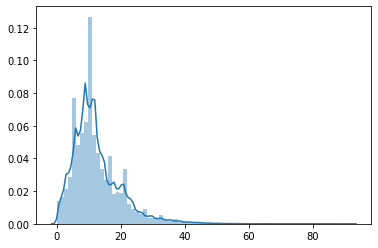

In [27]:
# Check the Distribution of Sentence Lengths 

sns.distplot(sent_lens, bins=75)
plt.show()

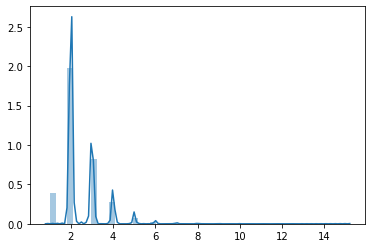

In [28]:
# Check the Distribution of Sentence Numbers for each Observation/Record

sns.distplot(sent_nums)
plt.show()


In [0]:
# Configuring Model for Training. This Can be Tuned (Hyperparameter Tuning) to produce good results. Can optimize based on Trial and Error

max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100 # We need to download glove 100d for this
VALIDATION_SPLIT = 0.2 # 20% validation


In [0]:
# Tokenizer for tokenizing the text sentences
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [31]:
# Tokenize words and sentence to list of array so that ,achine predicts based on it

data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass


and its
but if
gratisography
bob mcdonnell
— david
the hamilton creator
at johansson


In [32]:
# Check how the data is Sparsed and tokenisation of words in a record

data[:10]

array([[[  258,  1048,  3026, ...,     0,     0,     0],
        [    9,  2295,    11, ...,     0,     0,     0],
        [  388,     3, 57753, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[   99,    50,   287, ...,     0,     0,     0],
        [    2,   351,  3725, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  935,    32,   271, ...,     0,     0,     0],
        [   11,     2,  2268, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     

In [33]:
# Check the Shape of data

data.shape
# It Shows the Records, Max sentence numbers and Max sentence lengths

(200853, 6, 40)

In [34]:
# print the unique tokened words

word_index = tokenizer.word_index
print('There are a total of %s unique tokens present.' % len(word_index))

There are a total of 100266 unique tokens present.


In [0]:
# Target Variables loaded in binary form, by converting values to columns and assining 1 or 0 based on its prescence

categories = df['category']
labels = pd.get_dummies(categories)

In [0]:
# Get the Indices

indexes = np.arange(data.shape[0])

In [0]:
# Shuffle them before Training

np.random.shuffle(indexes) 

In [38]:
# Validate indexes

indexes

array([185568, 132146,  56389, ..., 123183,  62999,  78764])

In [0]:
# Creating Independant and Target data

data = data[indexes]
labels = labels.iloc[indexes]

In [41]:
# Target Variables as columns and each column contains binary 1 or 0 encoding
labels.columns

Index(['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE',
       'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION',
       'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS',
       'GREEN', 'HEALTHY LIVING', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES',
       'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES',
       'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE',
       'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WELLNESS',
       'WOMEN', 'WORLD NEWS', 'WORLDPOST'],
      dtype='object')

In [0]:
# Split by 20% as test/validation set
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [43]:
# Check no of Validation Samples
nb_validation_samples

40170

In [0]:
# Seperate Train and Validation Sets
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [46]:
# Print the Lengths of the Set

print("The length of Training set is", len(x_train))
print("The length of Validation set is", len(x_val))
print("The length of Target set is", len(y_train))
print("The length of Target Validation set is", len(y_val))

The length of Training set is 160683
The length of Validation set is 40170
The length of Target set is 160683
The length of Target Validation set is 40170


In [50]:
# As the test is binary for multiclass problem, check its columns, we predict based on index of top probablity occurance
y_train.columns[37]

'WELLNESS'

In [0]:
# Regularise to Prevent Overfitting
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)


In [0]:
# Download Pretrained Model of Glove Vector
# https://nlp.stanford.edu/projects/glove/
# For our task, we choose Glove 100d

In [53]:
# Encoding using Glove Vector and appending to dictionary

GLOVE_DIR = "/content/drive/My Drive/SPS_Dt/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('There are a total of %s word vectors.' % len(embeddings_index))


There are a total of 400000 word vectors.


In [54]:
# Find the Missing Words from Glove Vector

embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total missing words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')


Total missing words are 27655 which is 27.58 % of total words


In [55]:
# Embedding Layer

embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)


In [0]:
# Model Development for Word and Sentence Attention

word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))

preds = Dense(41, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [0]:
# Create Model Checkpoint so best model is saved automatically
checkpoint = ModelCheckpoint('best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [88]:
# Model Training
import time

start = time.time()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=512, callbacks=[checkpoint])
stop = time.time()

print(round((stop - start)/60, 2), "minutes is the Time taken to Train the model")

Train on 160683 samples, validate on 40170 samples
Epoch 1/50
160683/160683 [==============================] - 79s 494us/step - loss: 1.1026 - acc: 0.6796 - val_loss: 1.2174 - val_acc: 0.6506
Epoch 2/50
160683/160683 [==============================] - 79s 494us/step - loss: 1.0486 - acc: 0.6932 - val_loss: 1.2238 - val_acc: 0.6504
Epoch 3/50
160683/160683 [==============================] - 79s 494us/step - loss: 1.0026 - acc: 0.7052 - val_loss: 1.2453 - val_acc: 0.6444
Epoch 4/50
160683/160683 [==============================] - 79s 494us/step - loss: 0.9497 - acc: 0.7175 - val_loss: 1.2501 - val_acc: 0.6487
Epoch 5/50
160683/160683 [==============================] - 80s 495us/step - loss: 0.8991 - acc: 0.7316 - val_loss: 1.2750 - val_acc: 0.6445
Epoch 6/50
160683/160683 [==============================] - 79s 494us/step - loss: 0.8477 - acc: 0.7459 - val_loss: 1.2966 - val_acc: 0.6436
Epoch 7/50
160683/160683 [==============================] - 80s 497us/step - loss: 0.7953 - acc: 0.7593

In [0]:
# To Download the Model and serve it as h5 for Frontend

#from google.colab import files 
#files.download('best_model.h5')

In [90]:
# Printing the mokel keys

print(history.history.keys())


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


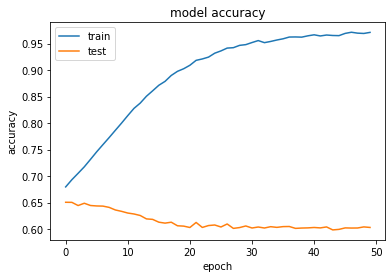

In [91]:
# Plotting history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


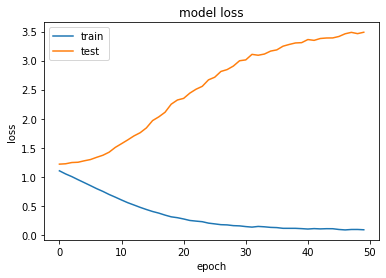

In [92]:
# Plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [93]:
# Input from the user end
content = str(input())

'''
Example Sentence:

Some elements are trying to scare people. We will respond at the right time," said Yusuf, who is pitted against AAP candidate and sitting MLA Imran Hussain and BJP's Lata Sodhi in Ballimaran.
The five-time MLA from the constituency also said if the Congress is voted to power in Delhi, it will bring in a resolution against the amended citizenship law, like the other party-ruled states.
He said the protest against the law and the National Register of Citizens was not just to "protect Muslims" but every poor Indian who could face trouble due to these measures.
'''

Some elements are trying to scare people. We will respond at the right time," said Yusuf, who is pitted against AAP candidate and sitting MLA Imran Hussain and BJP's Lata Sodhi in Ballimaran. The five-time MLA from the constituency also said if the Congress is voted to power in Delhi, it will bring in a resolution against the amended citizenship law, like the other party-ruled states. He said the protest against the law and the National Register of Citizens was not just to "protect Muslims" but every poor Indian who could face trouble due to these measures.


'\nExample Sentence:\n\nSome elements are trying to scare people. We will respond at the right time," said Yusuf, who is pitted against AAP candidate and sitting MLA Imran Hussain and BJP\'s Lata Sodhi in Ballimaran.\nThe five-time MLA from the constituency also said if the Congress is voted to power in Delhi, it will bring in a resolution against the amended citizenship law, like the other party-ruled states.\nHe said the protest against the law and the National Register of Citizens was not just to "protect Muslims" but every poor Indian who could face trouble due to these measures.\n'

In [0]:
# Perform Steps done for encoding of training data, so the distribution is same

paras1 = []
labels1 = []
texts1 = []
sent_lens1 = []
sent_nums1 = []
text = clean_str(content)
texts1.append(text)
sentences = tokenize.sent_tokenize(text)
sent_nums1.append(len(sentences))
for sent in sentences:
    sent_lens1.append(len(text_to_word_sequence(sent)))
paras1.append(sentences)


In [95]:
# Validate List of List containing seperate sentences
paras1

[['some elements are trying to scare people.',
  'we will respond at the right time, said yusuf, who is pitted against aap candidate and sitting mla imran hussain and bjps lata sodhi in ballimaran.',
  'the five-time mla from the constituency also said if the congress is voted to power in delhi, it will bring in a resolution against the amended citizenship law, like the other party-ruled states.',
  'he said the protest against the law and the national register of citizens was not just to protect muslims but every poor indian who could face trouble due to these measures.']]

In [0]:
# Fit the tokenizer for Text sentences

tokenizer1 = Tokenizer(num_words=max_features, oov_token=True)
tokenizer1.fit_on_texts(texts1)

In [0]:
# Predict the User input content by encoding and passing it as array

data1 = np.zeros((len(texts1), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras1):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer1.word_index[word]<max_features:
                        data1[i,j,k] = tokenizer1.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass


In [98]:
# Verify the output of the user input as array
data1

array([[[14, 15, 16, 17,  3, 18, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [20,  8, 21, 22,  2, 23,  9,  4, 24, 10, 11, 25,  5, 26, 27,  6,
         28, 12, 29, 30,  6, 31, 32, 33,  7, 34,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 35,  9, 12, 36,  2, 37, 38,  4, 39,  2, 40, 11, 41,  3, 42,
          7, 43, 44,  8, 45,  7, 46, 47,  5,  2, 48, 49, 13, 50,  2, 51,
         52, 53, 54,  0,  0,  0,  0,  0],
        [55,  4,  2, 56,  5,  2, 13,  6,  2, 57, 58, 59, 60, 61, 62, 63,
          3, 64, 65, 66, 67, 68, 69, 10, 70, 71, 72, 73,  3, 74, 75,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [0]:
# Predict the User text based on our Trained model

predor = model.predict(data1)

In [100]:
# Verify how the probablity is distributed among all output classes. The Output Probablity of the Multiclass problem should always sum up to 1

print(predor)
print('\n')
print("The Sum of all probablities sums up to", int(round(predor.sum())))

[[1.78562887e-02 1.14055979e-06 6.89046772e-07 5.38599610e-01
  2.94103636e-04 2.15400461e-04 5.66789822e-06 1.11705616e-04
  1.11313013e-03 4.55346126e-05 1.21848763e-03 1.32204082e-06
  1.33936286e-01 3.59801961e-05 4.78620859e-06 3.60872764e-05
  1.87320754e-01 4.06742009e-04 1.86171848e-04 5.74213618e-06
  2.76066312e-05 1.75669487e-03 1.27106626e-02 1.65254099e-03
  9.69053508e-06 3.81575286e-04 7.75328147e-07 1.21676945e-04
  1.91434865e-05 9.37682111e-03 1.49969116e-03 8.79906002e-05
  4.89301689e-04 5.34335459e-06 4.90419194e-02 1.45992017e-04
  1.60983527e-05 3.48906182e-02 6.01316150e-03 4.76458581e-06
  3.52245814e-04]]


The Sum of all probablities sums up to 1


In [101]:
# Get Index of the Maximum Probablity
np.argmax(predor)

3

In [102]:
# Output the Predicted Class for the User input

y_train.columns[np.argmax(predor)]

'BUSINESS'

### Testing the Predictor Function

In [0]:
# Perform Steps done for encoding of training data, so the distribution is same


def predictoroftext(content1):
    paras1 = []
    labels1 = []
    texts1 = []
    sent_lens1 = []
    sent_nums1 = []
    text = clean_str(content1)
    texts1.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums1.append(len(sentences))
    for sent in sentences:
        sent_lens1.append(len(text_to_word_sequence(sent)))
    paras1.append(sentences)

    # Fit the tokenizer for Text sentences

    tokenizer1 = Tokenizer(num_words=max_features, oov_token=True)
    tokenizer1.fit_on_texts(texts1)

    # Predict the User input content by encoding and passing it as array

    data1 = np.zeros((len(texts1), max_senten_num, max_senten_len), dtype='int32')
    for i, sentences in enumerate(paras1):
        for j, sent in enumerate(sentences):
            if j< max_senten_num:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                        if k<max_senten_len and tokenizer1.word_index[word]<max_features:
                            data1[i,j,k] = tokenizer1.word_index[word]
                            k=k+1
                    except:
                        print(word)
                        pass

    # Predict the User text based on our Trained model

    predor = model.predict(data1)

    # Output the Predicted Class for the User input

    return y_train.columns[np.argmax(predor)]


In [0]:
# Test

test = """
Pregnant women who are turned away from clinics spiral into debt and bankruptcy at startlingly high rates, according to a groundbreaking new study.
A new study offers a potent reminder of what really matters when it comes to economically empowering women: access to abortion.
Women who are blocked from getting abortions face significant financial distress, including higher amounts of debt and increased rates of bankruptcy and eviction, according to a groundbreaking working paper published last week by the National Bureau of Economic Research. 

"""

In [109]:
# Predict Class of Text
predictoroftext(test)

'HEALTHY LIVING'

In [0]:
test2 = """
White House Issues Formal Threat To Bolton To Keep Him From Publishing Book
The former national security adviser's book will reportedly outline several instances of presidential misconduct at issue in Trump's impeachment trial.
President Donald Trump’s impeachment trial is hurtling toward a showdown over whether the Senate will call witnesses to testify ― namely, former national security adviser John Bolton, who has written a book manuscript that effectively confirms the quid pro quo at the heart of the impeachment charges. 
Republican senators argue that calling Bolton or virtually any other witnesses would be a waste of time — because their vote won’t change. That argument is an accidental admission of the essential truth of this trial: Republicans are prepared to acquit Trump no matter what. 
Sen. Pat Toomey (R-Pa.), for example, said he was “very, very skeptical” that there would be a witness who would change his mind “about how I ought to vote on the final question.”
Graham’s colleagues have taken a similar stance. Sen. Cory Gardner (R-Colo.) said that “I do not believe we need to hear from an 18th witness,” despite Bolton’s new information. Sen. Ted Cruz (R-Texas) similarly argued that the House had already made its case and “additional witnesses are not necessary.” Sen. Jim Inhofe (R-Okla.) warned that calling witnesses would lead to a long string of people testifying and allow Democrats to “string this thing out.”
“Unless there’s a witness that’s going to change the outcome, I can’t imagine why we’d want to stretch this out for weeks and months,” Sen. Roy Blunt (R-Mo.) said earlier this week.
This is a far different stance than Graham and others took as recently as a few months ago, when they suggested that there was simply a lack of evidence to support the charges against the president.
"""

In [123]:
# Predict Class of Text 2
predictoroftext(test2)

'POLITICS'

In [0]:
## Thanks for your time